In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_csv("C:/Users/dell/Desktop/ml/bull/TrainAndValid.csv" , low_memory=False , parse_dates=["saledate"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

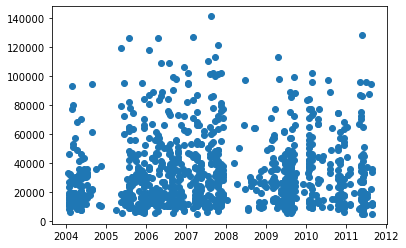

In [11]:
fig ,ax = plt.subplots()
ax.scatter(data["saledate"][:1000] , data["SalePrice"][:1000])

In [12]:
data.sort_values(by="saledate",inplace=True,ascending=True)
data.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [13]:
data_temp = data.copy()

In [14]:
def preprocess_data(data):
    data["saleyear"] = data.saledate.dt.year
    data["salemonth"] = data.saledate.dt.month
    data["saledayofyear"] = data.saledate.dt.dayofyear
    data["saledayofweek"] = data.saledate.dt.dayofweek
    
    data.drop("saledate" ,axis=1 , inplace=True)
    
    #converting string values into categorical values
    for label ,content in data.items():
        if pd.api.types.is_string_dtype(content):
            data[label] = content.astype("category").cat.as_ordered()
    
    #filling numeric missing values
    for label , content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                data[label + "ismissing"] = pd.isnull(content)
                data[label] = content.fillna(content.median())
                
    #filling string missing values
    for label ,content in data.items():
        if not pd.api.types.is_numeric_dtype(content):
            data[label + "ismissing"] = pd.isnull(content)
            data[label] = pd.Categorical(content).codes + 1
            
    return data    

In [54]:
# MAKING CUSTOM EVALUATION FUNCTION.
from sklearn.metrics import mean_absolute_error , mean_squared_log_error
def rmsle(ytest,ypreds):
    return np.sqrt(mean_squared_log_error(ytest , ypreds))
def show_scores(model):
    train_preds = model.predict(xtrain)
    val_preds   = model.predict(xvalid)
    scores = {"TRAINING MAE -> ":mean_absolute_error(ytrain , train_preds),
              "VALID MAR -> ": mean_absolute_error(yvalid , val_preds),
              "TRAINING RMSLE -> ": rmsle(ytrain,train_preds),
              "VALID RMSLE -> ": rmsle(yvalid , val_preds),
              "TRAINING R^2 -> ": model.score(xtrain , ytrain),
              "VALID R^2 -> ": model.score(xvalid , yvalid)}
    return scores    

In [15]:
data_temp = preprocess_data(data_temp)

In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 102 entries, SalesID to Steering_Controlsismissing
dtypes: bool(46), float64(3), int16(4), int64(9), int8(40)
memory usage: 77.9 MB


In [33]:
train_data = data_temp[data_temp["saleyear"]!=2012]
valid_data = data_temp[data_temp["saleyear"]==2012]

In [56]:
from sklearn.ensemble import RandomForestRegressor
reg_model = RandomForestRegressor(n_jobs = -1 , max_samples=10000)
xtrain = train_data.drop("SalePrice" , axis=1)
ytrain = train_data["SalePrice"]
xvalid = valid_data.drop("SalePrice" , axis=1)
yvalid = valid_data["SalePrice"]

In [57]:
len(xtrain) , len(xvalid)

(401125, 11573)

In [58]:
%%time
reg_model.fit(xtrain, ytrain)

Wall time: 8.35 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [59]:
show_scores(reg_model)

{'TRAINING MAE -> ': 5507.872906999064,
 'VALID MAR -> ': 7144.711459431435,
 'TRAINING RMSLE -> ': 0.2556741603772185,
 'VALID RMSLE -> ': 0.29348921291885227,
 'TRAINING R^2 -> ': 0.8629655636571905,
 'VALID R^2 -> ': 0.8331875840196737}

#### HYPERPARAMETER TUNING

In [83]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = {"n_estimators":np.arange(0,100,10),
           "max_depth":[None , 3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "max_features":[0.5,1,"sqrt","auto"],
           "max_samples":[10000]}
rs_model = RandomizedSearchCV(RandomForestRegressor() , param_distributions=rf_grid , n_iter=2,cv=5,verbose=True)
rs_model.fit(xtrain,ytrain)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [84]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 16,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [85]:
show_scores(rs_model)

{'TRAINING MAE -> ': 5795.0477192467415,
 'VALID MAR -> ': 7322.498434143682,
 'TRAINING RMSLE -> ': 0.2654693650500947,
 'VALID RMSLE -> ': 0.29824252381219146,
 'TRAINING R^2 -> ': 0.8484839173607384,
 'VALID R^2 -> ': 0.8250869291190593}

In [87]:
%%time
imodel = RandomForestRegressor(n_estimators=90 , min_samples_leaf=1,min_samples_split=14,max_features=0.5,n_jobs=-1,max_samples=None)
imodel.fit(xtrain,ytrain)

Wall time: 1min 34s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [88]:
show_scores(imodel)

{'TRAINING MAE -> ': 2964.55791708378,
 'VALID MAR -> ': 5917.235043766075,
 'TRAINING RMSLE -> ': 0.14484821236647638,
 'VALID RMSLE -> ': 0.2448163409603867,
 'TRAINING R^2 -> ': 0.9588072114532705,
 'VALID R^2 -> ': 0.8827378307486582}

In [90]:
test_data = pd.read_csv("C:/Users/dell/Desktop/ml/bull/Test.csv",low_memory=False,parse_dates=["saledate"])
test_data = preprocess_data(test_data)

In [91]:
set(xtrain)-set(test_data)

{'auctioneerIDismissing'}

In [93]:
test_data["auctioneerIDismissing"] = False

In [95]:
test_data.shape , xtrain.shape

((12457, 101), (401125, 101))

In [97]:
df_preds = pd.DataFrame()
test_preds = imodel.predict(test_data)
df_preds["SalesID"] = test_data["SalesID"]
df_preds["SalePrice"]     = test_preds
df_preds.head()

,SalesID,SalePrice
0,1227829,21331.790264
1,1227844,19893.362666
2,1227847,52176.598263
3,1227848,56508.115568
4,1227863,49751.816247


In [99]:
imodel.feature_importances_
# THE CONTRIBUTION OF EACH COLUMN IN THE FINAL RESULT

array([3.43345070e-02, 2.17415848e-02, 4.54001403e-02, 1.97597891e-03,
       3.53120947e-03, 1.98420101e-01, 3.27428920e-03, 1.11316861e-03,
       4.17318267e-02, 3.91797231e-02, 6.61339961e-02, 4.38612533e-03,
       1.80517793e-02, 1.52776525e-01, 4.01061049e-02, 6.38602910e-03,
       5.47890720e-03, 3.54693159e-03, 3.16432287e-03, 7.55831571e-02,
       4.62820845e-04, 3.71355038e-04, 7.99551207e-04, 1.74297969e-04,
       1.05764026e-03, 9.05388997e-05, 5.53329977e-04, 6.60260984e-03,
       3.90431749e-03, 2.21826553e-03, 4.24064363e-03, 2.54762316e-03,
       3.99123382e-03, 1.36652965e-03, 3.58399481e-03, 8.33601690e-03,
       9.30627449e-04, 1.08914031e-02, 2.18998272e-03, 1.66806883e-03,
       9.85319255e-04, 8.97265772e-04, 1.81547046e-03, 6.34780663e-04,
       5.33439411e-04, 3.85338550e-04, 3.16684595e-04, 2.22060578e-03,
       9.27628061e-04, 2.75350027e-04, 6.12122219e-04, 7.28617360e-02,
       4.08384828e-03, 1.05200420e-02, 3.13613679e-03, 2.86245976e-04,
      

In [110]:
import seaborn as sns
def plot_features_importance(columns , importances , n=20):
    df = (pd.DataFrame({
        "Features":columns,
        "Feature-Importance":importances,}).sort_values("Feature-Importance",ascending=False).reset_index(drop=True))
    fig , ax = plt.subplots(figsize=(10,6))
    sns.barplot(x="Feature-Importance" , y="Features",ax=ax,data=df[:n],orient="h")

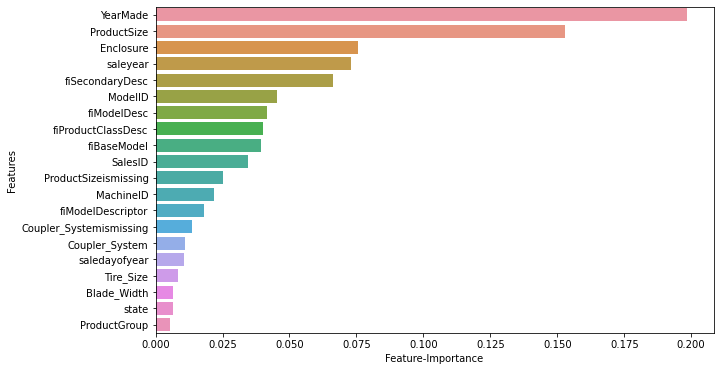

In [111]:
plot_features_importance(xtrain.columns , imodel.feature_importances_)